In [1]:
%run -i 'cosim_import.py'

0.post4546.dev0+g9aedd9c
2.8.0


In [2]:
import time
import sys
from tqdm import tqdm

In [3]:
caseH = 18
ict = True
ecc = False
agc = True

# --- ANDES case path ---
andes.config_logger(stream_level=50)
dir_path = os.path.abspath('..')
case_path = '/case/ieee39_eva.xlsx'
case = dir_path + case_path

# --- EV Aggregator ---
sse = ev_ssm(ts=caseH, N=500, step=1, tp=20,
             lr=0.1, lp=60, seed=2022, name="EVA",
             n_pref=1, is_report=True,
             tt_mean=0.2, tt_var=0.05, tt_lb=0, tt_ub=0.4,
             ict=ict, ecc=ecc, agc=agc)
sse.load_A("Aest.csv")

# --- EV info ---
ev_df = sse.ev.copy()
ev_df['p'] = -1 * ev_df['c'] * ev_df['Pc']
ev_df['gammap'] = ev_df['p'] / ev_df['p'].sum()
ev_df['gammaq'] = 1 / ev_df.u.sum()
ev_df['EtaC'] = ev_df['nc']
ev_df['EtaD'] = ev_df['nd']
ev_df['En'] = ev_df['Q'] / 1e3
ev_df['SOCinit'] = ev_df['soc'].replace(1, 0.999)

EVA: ts=18[H], 500 EVs, Total Q=4.38 MWh
Online 146, Q=3.64 MWh, SoC=0.7576
Power(MW): Pt=-0.3871, Pc=-0.3871, Pd=0.0
Ctrl: 0=82; 1=64; 
EVA: Load A from Aest.csv.


In [4]:
def init_ss(m=1):
    # load andes
    ss = andes.load(case,
                    setup=False,
                    no_output=True,
                    default_config=False)

    # Set output mode as 'manual', turn off TDS progress bar
    ss.TDS.config.save_mode = 'manual'
    ss.TDS.config.no_tqdm = 1

    # Set load as constant load.
    ss.PQ.config.p2p = 1
    ss.PQ.config.q2q = 1
    ss.PQ.config.p2z = 0
    ss.PQ.config.q2z = 0
    ss.PQ.pq2z = 0

    # Turn on ``numba`` can accelerate TDS.
    ss.config.numba = 1
    if m == 1:
        # write EV model into andes system
        for i in range(sse.ev.shape[0]):
            ev_dict = {'bus':38, 'gen':'PV_10',
                       'qmx': 10, 'qmn':-10, 'pmx':60, 'pmn':-70, 'pcap':1,
                       'gammap': 1, 'gammaq': 1, 'En': 10, 'EtaC': 10, 'EtaD': 10, 
                       'ddn':0, 'tip':0.02, 'tiq':0.02, 'ialim': 100, 'recflag':0,
                       'pqflag':1, 'vrflag':0}
            ss.add("EV2", ev_dict)

        ev_idx = ss.EV2.idx.v
        ss.DG.set(attr='v', idx=ev_idx, src='gammap', value=ev_df['gammap'].values)
        ss.DG.set(attr='v', idx=ev_idx, src='gammaq', value=ev_df['gammaq'].values)
        ss.DG.set(attr='v', idx=ev_idx, src='EtaC', value=ev_df['EtaC'].values)
        ss.DG.set(attr='v', idx=ev_idx, src='EtaD', value=ev_df['EtaD'].values)
        ss.DG.set(attr='v', idx=ev_idx, src='En', value=ev_df['En'].values)
        ss.DG.set(attr='v', idx=ev_idx, src='SOCinit', value=ev_df['SOCinit'].values)
        ss.DG.set(attr='v', idx=ev_idx, src='u', value=ev_df['u'].values)
    elif m == 2:
        # write EV model into andes system
        ev0_dict = {'bus':38, 'gen':'PV_10',
                    'qmx': 10, 'qmn':-10, 'pmx':60, 'pmn':-70, 'pcap':1,
                    'gammap': 1, 'gammaq': 1, 'En': 10, 'EtaC': ev_df['EtaC'].mean(),
                    'EtaD': ev_df['EtaD'].mean(), 
                    'ddn':0, 'tip':0.02, 'tiq':0.02, 'ialim': 100, 'recflag':0,
                    'pqflag':1, 'vrflag':0}
        ss.add("EV2", ev0_dict)

    p0 = ev_df['p'].sum() / 1e3 / ss.config.mva
    ss.StaticGen.set(src='p0', attr='v', idx='PV_10', value=p0)
    ss.setup()
    ss.PFlow.run()
    init_ss = ss.TDS.init()
    return ss

def run_ss(m=1, time_len=10, no_tqdm=False):
    ss = init_ss(m=m)
    sse = ev_ssm(ts=caseH, N=500, step=1, tp=20,
                 lr=0.1, lp=60, seed=2022, name="EVA",
                 n_pref=1, is_report=True,
                 tt_mean=0.2, tt_var=0.05, tt_lb=0, tt_ub=0.4,
                 ict=ict, ecc=ecc, agc=agc)
    sse.load_A("Aest.csv")
    for end_time in tqdm(range(1, time_len), disable=no_tqdm):
        sse.run(tf=caseH+end_time/3600, Pi=0,
                is_updateA=False, is_rstate=True,
                is_test=False, disable=True)
        ev_idx = ss.EV2.idx.v
        ss.DG.set(attr='v', idx=ev_idx, src='u', value=sse.ev['u'].values)
        if m == 1:
            p_value = list(-1 * sse.ev['c'] * sse.ev['Pc'] / ss.config.mva / 1e3)
        elif m == 2:
            p_value = np.sum(list(-1 * sse.ev['c'] * sse.ev['Pc'] / ss.config.mva / 1e3))
        ss.DG.set(attr='v', idx=ev_idx, src='pref0',
                  value=p_value)

        ss.TDS.config.tf = end_time
        ss.TDS.run()
        if ss.exit_code != 0:
            break
    # --- calcualte output power ---
    ia = ss.dae.ts.x[:, ss.EV2.Ipout_y.a]
    va = ss.dae.ts.y[:, ss.EV2.v.a]
    pa = np.sum(ia * va * ss.config.mva, axis=1)
    return ss, sse, pa

def crun_ss(m=1):
    ss = andes.load(case,
                     setup=False,
                     no_output=True,
                     default_config=False)
    ss.add('Toggler', dict(model="GENROU", dev='GENROU_2', t=1.0))

    # Set output mode as 'manual', turn off TDS progress bar
    ss.TDS.config.save_mode = 'manual'
    ss.TDS.config.no_tqdm = 1

    # Set load as constant load.
    ss.PQ.config.p2p = 1
    ss.PQ.config.q2q = 1
    ss.PQ.config.p2z = 0
    ss.PQ.config.q2z = 0
    ss.PQ.pq2z = 0

    # Turn on ``numba`` can accelerate TDS.
    ss.config.numba = 1
    if m == 1:
        # write EV model into andes system
        for i in range(sse.ev.shape[0]):
            ev_dict = {'bus':38, 'gen':'PV_10',
                       'qmx': 10, 'qmn':-10, 'pmx':60, 'pmn':-70, 'pcap':1,
                       'gammap': 1, 'gammaq': 1, 'En': 10, 'EtaC': 10, 'EtaD': 10, 
                       'ddn':0, 'tip':0.02, 'tiq':0.02, 'ialim': 100, 'recflag':0,
                       'pqflag':1, 'vrflag':0}
            ss.add("EV2", ev_dict)

        ev_idx = ss.EV2.idx.v
        ss.DG.set(attr='v', idx=ev_idx, src='gammap', value=ev_df['gammap'].values)
        ss.DG.set(attr='v', idx=ev_idx, src='gammaq', value=ev_df['gammaq'].values)
        ss.DG.set(attr='v', idx=ev_idx, src='EtaC', value=ev_df['EtaC'].values)
        ss.DG.set(attr='v', idx=ev_idx, src='EtaD', value=ev_df['EtaD'].values)
        ss.DG.set(attr='v', idx=ev_idx, src='En', value=ev_df['En'].values)
        ss.DG.set(attr='v', idx=ev_idx, src='SOCinit', value=ev_df['SOCinit'].values)
        ss.DG.set(attr='v', idx=ev_idx, src='u', value=ev_df['u'].values)
    elif m == 2:
        # write EV model into andes system
        ev0_dict = {'bus':38, 'gen':'PV_10',
                    'qmx': 10, 'qmn':-10, 'pmx':60, 'pmn':-70, 'pcap':1,
                    'gammap': 1, 'gammaq': 1, 'En': 10, 'EtaC': ev_df['EtaC'].mean(),
                    'EtaD': ev_df['EtaD'].mean(), 
                    'ddn':0, 'tip':0.02, 'tiq':0.02, 'ialim': 100, 'recflag':0,
                    'pqflag':1, 'vrflag':0}
        ss.add("EV2", ev0_dict)

    p0 = ev_df['p'].sum() / 1e3 / ss.config.mva
    ss.StaticGen.set(src='p0', attr='v', idx='PV_10', value=p0)
    ss.setup()
    ss.PFlow.run()
    ss.TDS.init()
    ss.TDS.config.tf = 50
    ss.TDS.run()
    # --- calcualte output power ---
    ia = ss.dae.ts.x[:, ss.EV2.Ipout_y.a]
    va = ss.dae.ts.y[:, ss.EV2.v.a]
    pa = np.sum(ia * va * ss.config.mva, axis=1)
    return ss, pa

In [5]:
# --- contingency ---

# # run
tcs = time.time()
ss1y, pa1y = crun_ss(m=1)
tcs1 = time.time()
ss2y, pa2y = crun_ss(m=2)
tcs2 = time.time()
print(f"M1 runs {tcs1 - tcs}s, M2 runs {tcs2 - tcs1}s")

Generating code for 1 models on 8 processes.
<Toggle Toggler_2>: GENROU.GENROU_2 status changed to 0 at t=1.0 sec.
Generating code for 1 models on 8 processes.
<Toggle Toggler_2>: GENROU.GENROU_2 status changed to 0 at t=1.0 sec.
M1 runs 5.575785398483276s, M2 runs 3.359902858734131s


Text(2112.343434343434, 0.5, 'Freq. [Hz]')

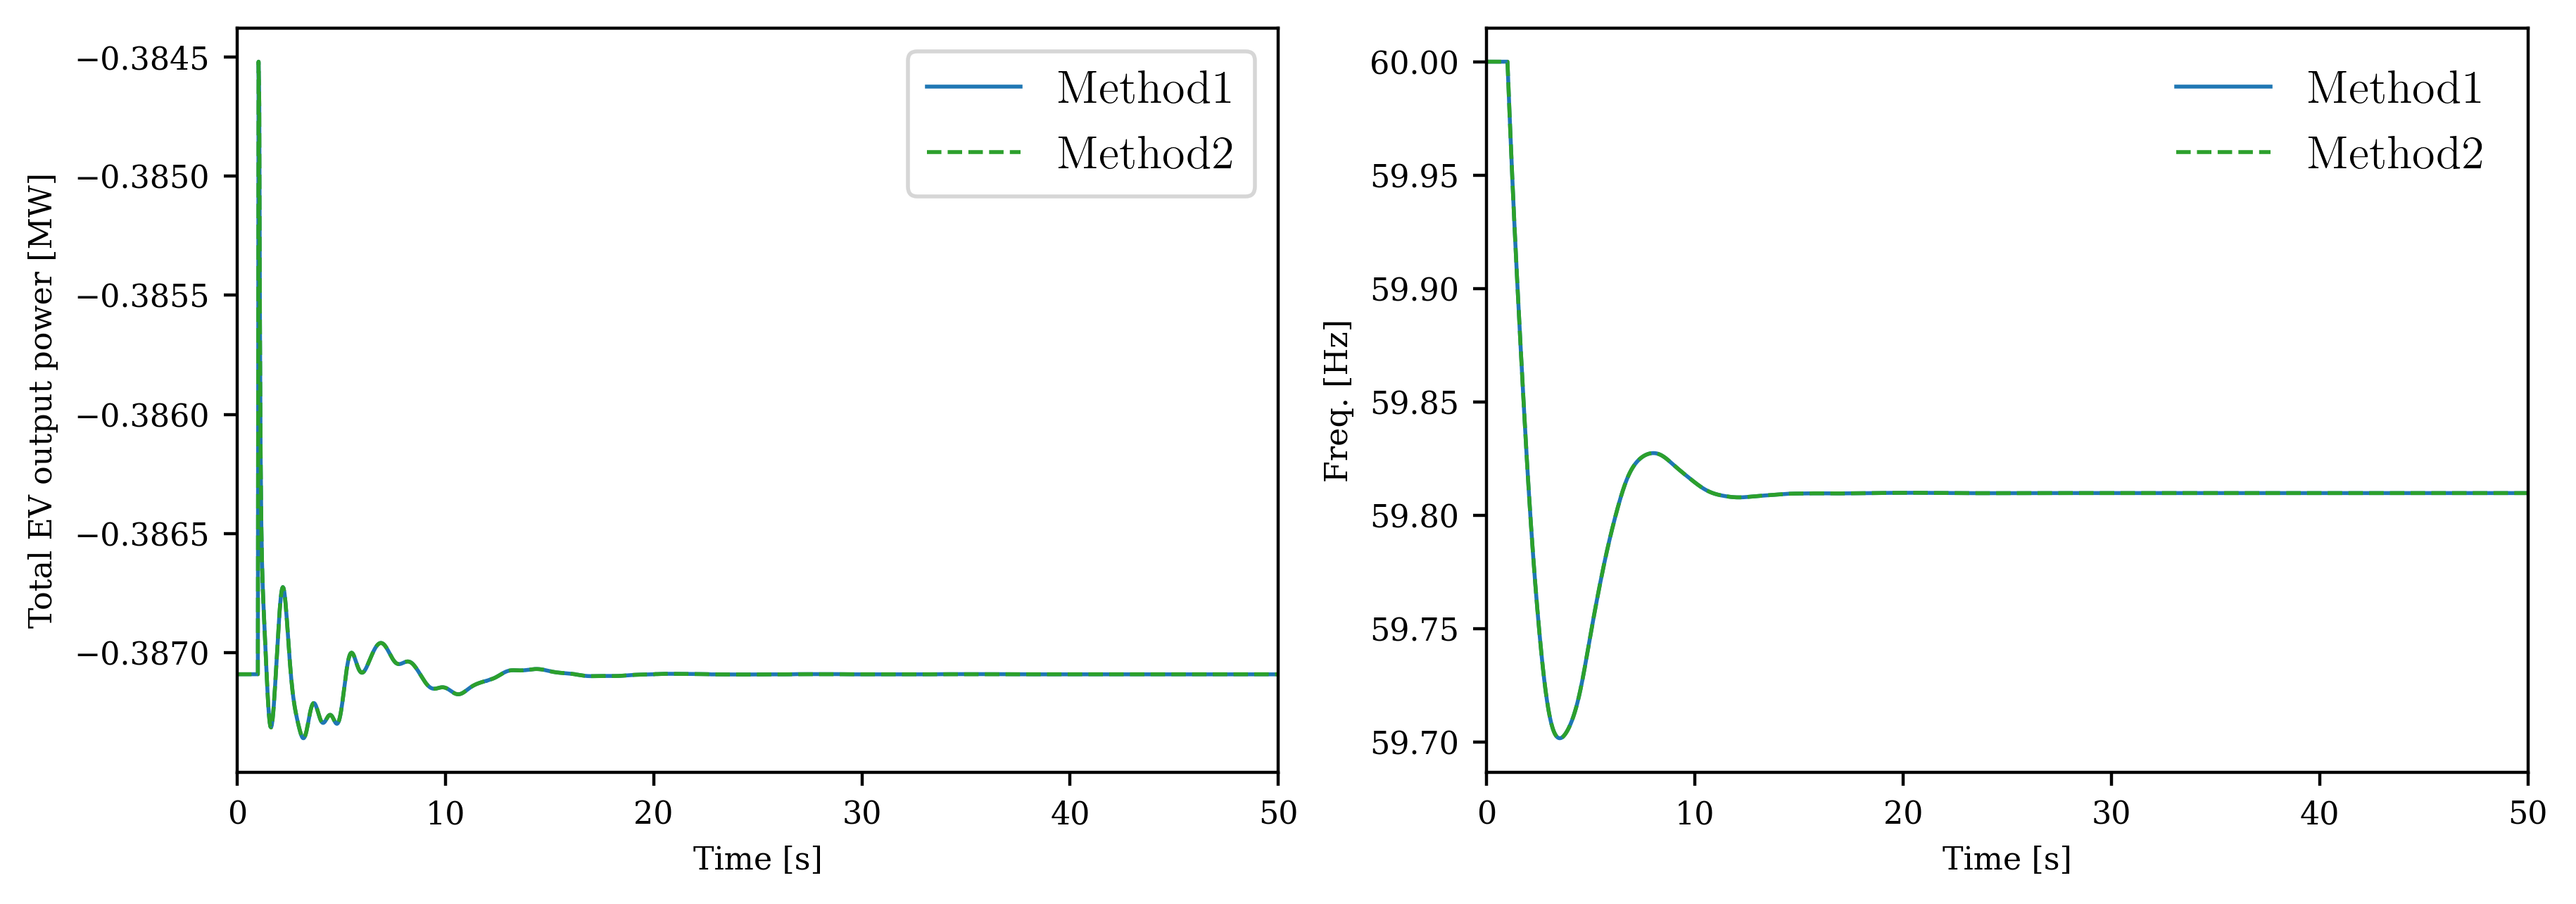

In [6]:
# # plot
plt.style.use("ieee")
fig, ax = plt.subplots(1, 2, figsize=(10.5, 3.5), dpi=400)
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.2, hspace=None)

ss1y.TDS.plt.plot_data(ss1y.dae.ts.t, pa1y, yheader=["Method1"],
                      color="tab:blue", ax=ax[0], fig=fig, show=False)
ss2y.TDS.plt.plot_data(ss2y.dae.ts.t, pa2y, yheader=["Method2"], linestyles=['--'], 
                      color="tab:green", ax=ax[0], fig=fig, show=False)
ax[0].legend()
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Total EV output power [MW]")

ss1y.TDS.plt.plot(ss1y.COI.omega, ytimes=60, ax=ax[1], fig=fig, yheader=['Method1'],
                  color="tab:blue", show=False)
ss2y.TDS.plt.plot(ss2y.COI.omega, ytimes=60, ax=ax[1], fig=fig, yheader=["Method2"],
                  color="tab:green",  linestyles=['--'], show=False, alpha=0.8)
ax[1].set_ylabel('Freq. [Hz]')

In [ ]:
# --- normal operation ---

# # run
end_time = 1200  # 3600
ss1x, se1x, pa1x = run_ss(m=1, time_len=end_time)

Generating code for 1 models on 8 processes.


EVA: ts=18[H], 500 EVs, Total Q=4.38 MWh
Online 146, Q=3.64 MWh, SoC=0.7576
Power(MW): Pt=-0.3871, Pc=-0.3871, Pd=0.0
Ctrl: 0=82; 1=64; 
EVA: Load A from Aest.csv.
 66%|████████████████████████████████████████████████████████████▎                              | 795/1199 [11:50<20:20,  3.02s/it]

In [ ]:
ss2x, se2x, pa2x = run_ss(m=2, time_len=end_time)

In [ ]:
# # plot
plt.style.use("ieee")
fig, ax = plt.subplots(1, 2, figsize=(10.5, 3.5), dpi=400)
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.25, hspace=None)
ss1x.TDS.plt.plot_data(ss1x.dae.ts.t, pa1x, yheader=["Method1"],
                       color="tab:blue", ax=ax[0], fig=fig, show=False)
ss2x.TDS.plt.plot_data(ss2x.dae.ts.t, pa2x, yheader=["Method2"], linestyles=['--'], 
                       color="tab:green", ax=ax[0], fig=fig, show=False)
ax[0].legend()
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Total EV output power [MW]")

ss1x.TDS.plt.plot(ss1x.COI.omega, ytimes=60, ax=ax[1], fig=fig, yheader=['Method1'],
                  color="tab:blue", show=False)
ss2x.TDS.plt.plot(ss2x.COI.omega, ytimes=60, ax=ax[1], fig=fig, yheader=["Method2"],
                  color="tab:green",  linestyles=['--'], show=False, alpha=0.8)
ax[1].set_ylabel('Freq. [Hz]')

In [ ]:
ss1 = init_ss(m=1)
ss2 = init_ss(m=2)

size_ss1 = sys.getsizeof(ss1.EV2)
size_ss2 = sys.getsizeof(ss2.EV2)
print(f'ss1 size={size_ss1}, ss2 size={size_ss2}')

In [ ]:
end_time = 10

In [ ]:
%%timeit -n 10 -r 5
ss1, se1, pa1 = run_ss(m=1, time_len=end_time, no_tqdm=True)

In [ ]:
%%timeit -n 10 -r 5
ss2, se2, pa2 = run_ss(m=2, time_len=end_time, no_tqdm=True)

In [ ]:
# %%timeit -n 10 -r 5
# # --- Method1: write model ---
# ss1 = init_ss(m=1)

# %%timeit -n 10 -r 5
# # --- Method2: write model ---
# ss2 = init_ss(m=2)